<a href="https://colab.research.google.com/github/abhaysinghrathore-dev/LEVERAGING_NLP_AND_GENERATIVE_AI_FOR_VISUAL_UNKNOWN_CLASSIFICATION_AND_IDENTIFICATION/blob/main/LEVERAGING_NLP_AND_GENERATIVE_AI_FOR_VISUAL_UNKNOWN_CLASSIFICATION_AND_IDENTIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Importing Libraries

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split, Dataset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Check the available device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)  # Output the device that will be used


cuda


2. Data Loading and Preprocessing

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Move the uploaded file to the appropriate directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# Download dataset using Kaggle API
!kaggle datasets download -d jessicali9530/caltech256 -p /content/ --unzip

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/caltech256
License(s): other
100% 2.12G/2.12G [01:49<00:00, 24.4MB/s]
100% 2.12G/2.12G [01:49<00:00, 20.8MB/s]


In [ ]:
# Preprocessing during data loading
transform = transforms.Compose([
    transforms.Resize(256),          # Resize the images to 256x256
    transforms.CenterCrop(224),      # Crop the images to 224x224 from the center
    transforms.ToTensor(),           # Convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the tensors
])


In [ ]:
# Load the dataset
dataset = datasets.ImageFolder("/content/256_objectcategories/256_ObjectCategories/", transform=transform)


In [ ]:
# Check the number of classes
num_classes = len(dataset.classes)
print("Number of classes:", num_classes)

# Check the size of the dataset
print("Total images:", len(dataset))


Number of classes: 257
Total images: 30607


In [ ]:
# Split the data into training and testing sets
train_size = int(0.8 * len(dataset))  # Assign 80% of the data for training
test_size = len(dataset) - train_size  # The rest for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print("Training images:", len(train_dataset))  # Print the number of training images
print("Testing images:", len(test_dataset))    # Print the number of testing images

# List the labels of the classes being classified
classes = dataset.classes
print(classes)  # Print the class labels


Training images: 24485
Testing images: 6122
['001.ak47', '002.american-flag', '003.backpack', '004.baseball-bat', '005.baseball-glove', '006.basketball-hoop', '007.bat', '008.bathtub', '009.bear', '010.beer-mug', '011.billiards', '012.binoculars', '013.birdbath', '014.blimp', '015.bonsai-101', '016.boom-box', '017.bowling-ball', '018.bowling-pin', '019.boxing-glove', '020.brain-101', '021.breadmaker', '022.buddha-101', '023.bulldozer', '024.butterfly', '025.cactus', '026.cake', '027.calculator', '028.camel', '029.cannon', '030.canoe', '031.car-tire', '032.cartman', '033.cd', '034.centipede', '035.cereal-box', '036.chandelier-101', '037.chess-board', '038.chimp', '039.chopsticks', '040.cockroach', '041.coffee-mug', '042.coffin', '043.coin', '044.comet', '045.computer-keyboard', '046.computer-monitor', '047.computer-mouse', '048.conch', '049.cormorant', '050.covered-wagon', '051.cowboy-hat', '052.crab-101', '053.desk-globe', '054.diamond-ring', '055.dice', '056.dog', '057.dolphin-101', '

In [ ]:
# Remove "00X" prefixes from class names
import re
classes = [re.sub(r"^\d+\.\s*", "", item) for item in classes]  # Use regex to strip numeric prefixes followed by a dot and space
print(classes)  # Print the updated class names


['ak47', 'american-flag', 'backpack', 'baseball-bat', 'baseball-glove', 'basketball-hoop', 'bat', 'bathtub', 'bear', 'beer-mug', 'billiards', 'binoculars', 'birdbath', 'blimp', 'bonsai-101', 'boom-box', 'bowling-ball', 'bowling-pin', 'boxing-glove', 'brain-101', 'breadmaker', 'buddha-101', 'bulldozer', 'butterfly', 'cactus', 'cake', 'calculator', 'camel', 'cannon', 'canoe', 'car-tire', 'cartman', 'cd', 'centipede', 'cereal-box', 'chandelier-101', 'chess-board', 'chimp', 'chopsticks', 'cockroach', 'coffee-mug', 'coffin', 'coin', 'comet', 'computer-keyboard', 'computer-monitor', 'computer-mouse', 'conch', 'cormorant', 'covered-wagon', 'cowboy-hat', 'crab-101', 'desk-globe', 'diamond-ring', 'dice', 'dog', 'dolphin-101', 'doorknob', 'drinking-straw', 'duck', 'dumb-bell', 'eiffel-tower', 'electric-guitar-101', 'elephant-101', 'elk', 'ewer-101', 'eyeglasses', 'fern', 'fighter-jet', 'fire-extinguisher', 'fire-hydrant', 'fire-truck', 'fireworks', 'flashlight', 'floppy-disk', 'football-helmet',

In [ ]:
# Create data loaders
batch_size = 128  # Set the batch size for loading data
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)  # DataLoader for training data
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)    # DataLoader for testing data


visualize

In [ ]:
train_iter = iter(train_loader)
imgs, labels = next(train_iter)
labels

tensor([208, 128, 204, 220,  22,  91, 251, 217, 121,  10, 123, 183, 219, 211,
        218,  98, 244, 237, 255, 196, 187,  15, 170, 250, 236, 195, 235, 152,
        125, 205, 242, 228, 122, 246, 156, 158, 190, 137, 139, 106, 136,  27,
        202,  22,  54,   1,  73, 102, 146, 118, 144, 144, 120,  60,  56,  33,
        112, 222,  63, 111, 100, 129, 215, 256,  85,  29,  45, 140,  20,  10,
        137, 115, 144,   7,  49, 100, 199, 114,  88, 224,   7, 194, 193, 255,
         54, 221,  42,  36, 121, 198, 175, 154, 239, 207,   5, 250, 161, 147,
        103, 240, 125,  71, 140,  59, 153, 239,  95,  42,  75, 184,  50,  61,
        232,  79, 206,  34, 108,  32, 202, 237, 248, 256, 147, 104, 189,  43,
         21, 256])

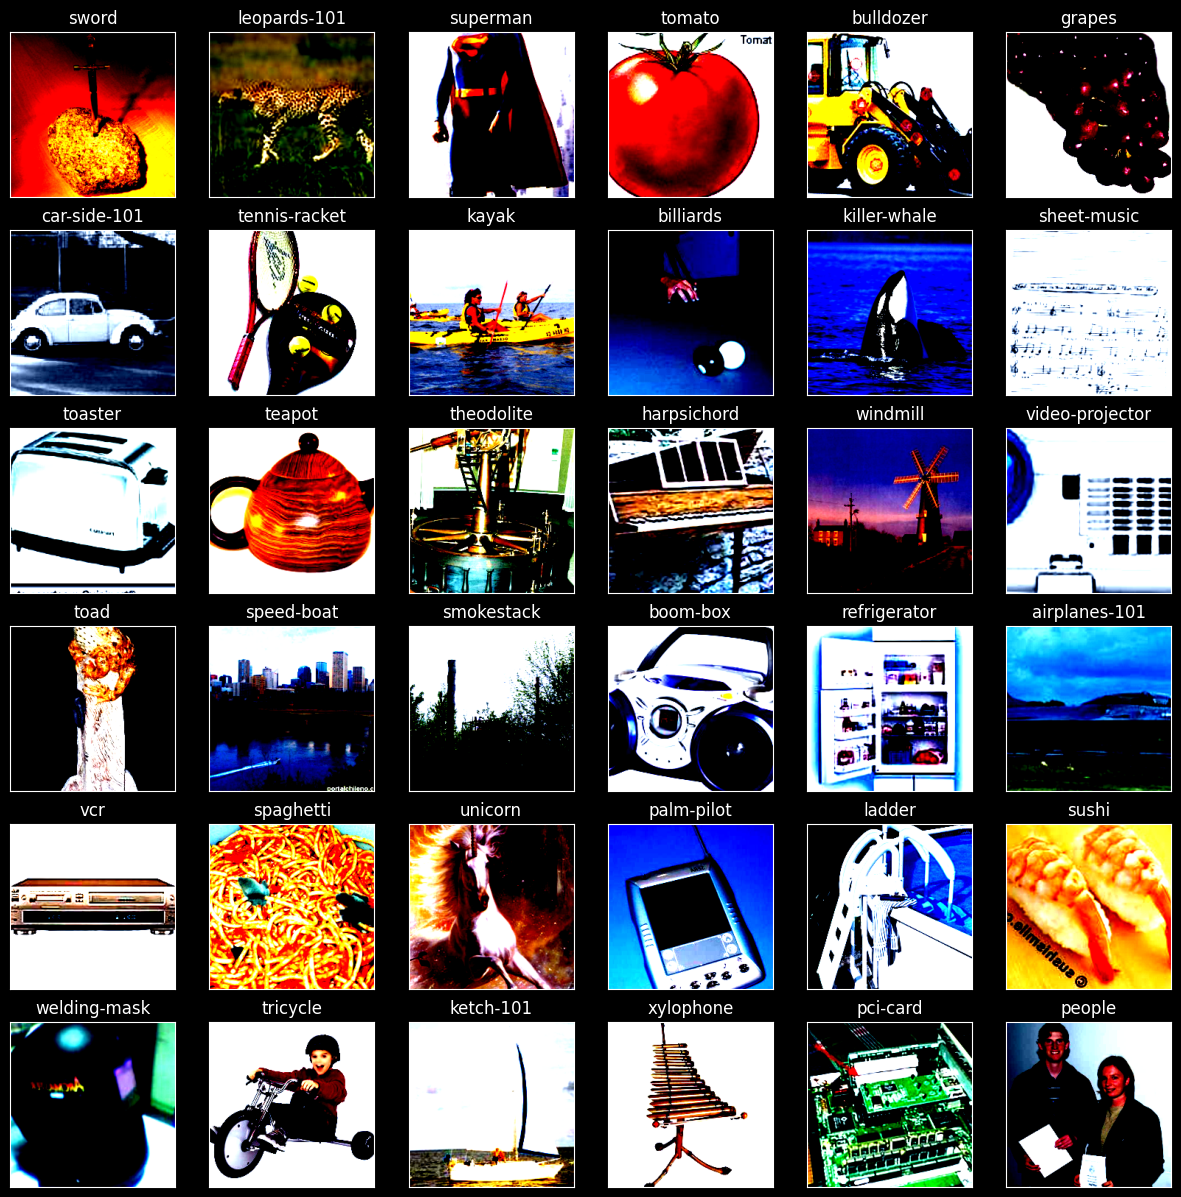

In [ ]:

plt.style.use("dark_background")
plt.figure(figsize=(15, 15))
for i in range(36):
    ax = plt.subplot(6, 6, i+1, xticks=[], yticks=[])
    # Clip values outside the range to 0 or 1
    imgs[i] = np.clip(imgs[i], 0, 1)
    # Convert to channel last format
    ax.imshow(imgs[i].permute(1, 2, 0))
    # Get the image name
    label = classes[labels[i]]
    ax.set_title(label, fontsize=12)
plt.show()


3. proposed methodology

In [ ]:
net = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 178MB/s]


In [ ]:
# Disable training for all layers initially
for param in net.parameters():
    param.requires_grad = False

# Modify the last classifier layer to classify into 257 classes
net.classifier[0] = nn.Dropout(p=0.3, inplace=True)  # Adding dropout to reduce overfitting
net.classifier[1] = nn.Linear(in_features=1536, out_features=257)  # Replacing the final linear layer

# Transfer the model to CUDA for GPU acceleration
net.cuda()

print(net)  # Print the model structure to confirm changes


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

4. Training

In [ ]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimization algorithm
from torch import optim
optimizer = optim.Adam(params=net.parameters(), lr=0.001)  # Using Adam optimizer with a learning rate of 0.001


In [ ]:
# Training
num_epochs = 20

# Lists to store training and testing metrics
losses = []
accs = []
t_losses = []
t_accs = []

for epoch in range(num_epochs):
    # Set the model to training mode
    net.train()
    running_loss = 0.0
    running_acc = 0.0
    for i, (imgs, labels) in enumerate(train_loader):
        # Transfer data to CUDA
        imgs, labels = imgs.cuda(), labels.cuda()
        # Initialize the optimization algorithm
        optimizer.zero_grad()
        # Forward pass (classification)
        outputs = net(imgs)
        # Calculate the loss
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        # Calculate accuracy
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        running_acc += acc.item()
        # Backpropagation
        loss.backward()
        # Update weights
        optimizer.step()
    # Average the loss and store it
    running_loss /= len(train_loader)
    losses.append(running_loss)
    # Average the accuracy and store it
    running_acc /= len(train_loader)
    accs.append(running_acc)

    # Set the model to evaluation mode
    net.eval()
    t_running_loss = 0.0
    t_running_acc = 0.0
    with torch.no_grad():
        for j, (t_imgs, t_labels) in enumerate(test_loader):
            t_imgs, t_labels = t_imgs.cuda(), t_labels.cuda()
            t_outputs = net(t_imgs)
            t_loss = criterion(t_outputs, t_labels)
            t_running_loss += t_loss.item()
            t_acc = (t_outputs.argmax(dim=1) == t_labels).float().mean()
            t_running_acc += t_acc.item()
        t_running_loss /= len(test_loader)
        t_losses.append(t_running_loss)
        t_running_acc /= len(test_loader)
        t_accs.append(t_running_acc)

    # Print loss and accuracy for each epoch
    print(f"Epoch: {epoch}, Train Loss: {running_loss:.4f}, Train Acc: {running_acc:.4f}")
    print(f"Epoch: {epoch}, Test Loss: {t_running_loss:.4f}, Test Acc: {t_running_acc:.4f}")
    print("=" * 100)


Epoch: 0, Train Loss: 2.9508, Train Acc: 0.6033
Epoch: 0, Test Loss: 1.4146, Test Acc: 0.8104
Epoch: 1, Train Loss: 1.0439, Train Acc: 0.8235
Epoch: 1, Test Loss: 0.8772, Test Acc: 0.8346
Epoch: 2, Train Loss: 0.7180, Train Acc: 0.8573
Epoch: 2, Test Loss: 0.7320, Test Acc: 0.8435
Epoch: 3, Train Loss: 0.5760, Train Acc: 0.8776
Epoch: 3, Test Loss: 0.6553, Test Acc: 0.8487
Epoch: 4, Train Loss: 0.4935, Train Acc: 0.8902
Epoch: 4, Test Loss: 0.6303, Test Acc: 0.8545
Epoch: 5, Train Loss: 0.4268, Train Acc: 0.9019
Epoch: 5, Test Loss: 0.6083, Test Acc: 0.8498
Epoch: 6, Train Loss: 0.3782, Train Acc: 0.9136
Epoch: 6, Test Loss: 0.5858, Test Acc: 0.8562
Epoch: 7, Train Loss: 0.3388, Train Acc: 0.9207
Epoch: 7, Test Loss: 0.5724, Test Acc: 0.8599


In [ ]:
# Plot the transition of loss
import matplotlib.pyplot as plt
import torch

plt.style.use("ggplot")  # Use ggplot style for more refined visuals
plt.plot(losses, label="train", color="blue")  # Plot training losses
plt.plot(t_losses, label="test", color="red")  # Plot testing losses
plt.legend()  # Show legend to distinguish train and test
plt.xlabel("Epochs")  # Label the x-axis as 'Epochs'
plt.ylabel("Loss")  # Label the y-axis as 'Loss'
plt.title("Loss vs Epoch")  # Set the title of the plot
plt.xticks(torch.arange(0, num_epochs + 1, 1))  # Set the x-ticks to show each epoch
plt.show()  # Display the plot


In [ ]:
# Plot the transition of accuracy
import matplotlib.pyplot as plt
import torch

plt.plot(accs, label="train", color="green")  # Plot training accuracy
plt.plot(t_accs, label="test", color="orange")  # Plot testing accuracy
plt.legend()  # Show legend to distinguish between train and test accuracy
plt.xlabel("Epochs")  # Label the x-axis as 'Epochs'
plt.ylabel("Accuracy")  # Label the y-axis as 'Accuracy'
plt.title("Accuracy vs Epoch")  # Set the title of the plot
plt.xticks(torch.arange(0, 21, 1))  # Set the x-ticks to show each epoch
plt.show()  # Display the plot


5. Performance

In [ ]:
# Initialize counters for correct predictions and total samples
correct = 0
total = 0

# Set the model to evaluation mode
net.eval()
for j, (t_imgs, t_labels) in enumerate(test_loader):
    # Transfer images and labels to CUDA (GPU)
    t_imgs, t_labels = t_imgs.cuda(), t_labels.cuda()
    # Perform classification
    t_outputs = net(t_imgs)
    # Calculate the number of correct predictions
    correct += (torch.argmax(t_outputs, dim=1)).eq(t_labels).sum().item()
    # Update total number of images processed
    total += t_labels.size(0)

# Calculate and print the accuracy percentage
print(f"Accuracy: {correct / total * 100:.2f}%")


In [ ]:
# Create a DataLoader for only one batch of size 36
batch_size = 36
data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
data_iter = iter(data_loader)
images, labels = next(data_iter)

# Display images from index 0 to 35
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 15))
for i in range(batch_size):
    plt.subplot(6, 6, i+1)
    plt.style.use("dark_background")
    images[i] = np.clip(images[i], 0, 1)  # Clip the image to normalize
    # Convert to channel last format for display
    plt.imshow(images[i].permute(1, 2, 0))
    # Hide grid and labels to improve visual clarity
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
    # Display the true label for each image
    plt.title(f"Label: {classes[labels[i]]}", fontsize=10)
plt.tight_layout()
plt.show()

# Set model to evaluation mode
net.eval()
# Transfer images to CUDA for model inference
t_imgs, t_labels = images.cuda(), labels.cuda()
outputs = net(t_imgs)
# Print the actual and predicted labels
for i in range(batch_size):
    predicted_label = classes[torch.argmax(outputs[i], dim=0).item()]
    true_label = classes[labels[i]]
    print(f"Actual: {true_label}, Prediction: {predicted_label}")


Thank You